# Bibliotecas

In [ ]:
import os
import torch
import timm
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision.models import resnet50
import torch.nn.functional as F
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from torchvision import models
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import os
import timm
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Funções de treinamento do modelo

In [ ]:
def train_feature_extractor(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)

            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        val_loss, _, _, _ = evaluate_feature_extractor(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Curves")
    plt.show()

    return model


In [ ]:
def evaluate_feature_extractor(model, loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            embeddings = model(images)

            loss = criterion(embeddings, labels)
            running_loss += loss.item() * images.size(0)

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, None, None, None  #


In [ ]:
def extrair_features(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            embeddings = model(images)
            features.append(embeddings.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels


# ViT Hibrido

In [ ]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).

    patch_size : int
        Size of the patch (it is a square).

    in_chans : int
        Number of input channels.

    embed_dim : int
        The emmbedding dimension.

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.

    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size

        self.n_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)


    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(x)  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x


class Attention(nn.Module):
    """Attention mechanism.

    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.

    n_heads : int
        Number of attention heads.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    attn_p : float
        Dropout probability applied to the query, key and value tensors.

    proj_p : float
        Dropout probability applied to the output tensor.


    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.

    qkv : nn.Linear
        Linear projection for the query, key and value.

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.

    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x


class MLP(nn.Module):
    """Multilayer perceptron.

    Parameters
    ----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer.

    out_features : int
        Number of output features.

    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.

    act : nn.GELU
        GELU activation function.

    fc2 : nn.Linear
        The second linear layer.

    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x


class Block(nn.Module):
    """Transformer block.

    Parameters
    ----------
    dim : int
        Embeddinig dimension.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.

    attn : Attention
        Attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, funcao_ativacao ,stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

    if in_channels == out_channels * self.expansion:
      self.identity = True
    else:
      self.identity = False
      self.projection = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, padding=0, bias=False),
          nn.BatchNorm2d(out_channels * self.expansion)
      )

    self.func_ativacao = funcao_ativacao

  def forward(self, x):
    identity = x
    x = self.func_ativacao(self.bn1(self.conv1(x)))
    x = self.func_ativacao(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))

    if self.identity:
      x += identity
    else:
      x += self.projection(identity)

    x = self.func_ativacao(x)

    return x


class ResNetBackbone(nn.Module):
    def __init__(self, Bottleneck, num_blocks, num_channels, funcao_ativacao):

        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.func_ativacao = funcao_ativacao
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.block1 = self._make_layer(Bottleneck, 64, num_blocks[0], stride=1)
        self.block2 = self._make_layer(Bottleneck, 128, num_blocks[1], stride=2)
        self.block3 = self._make_layer(Bottleneck, 256, num_blocks[2], stride=2)
        self.block4 = self._make_layer(Bottleneck, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Identity()
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, Bottleneck, out_channels, num_blocks, stride):
        layers = [Bottleneck(self.in_channels, out_channels, funcao_ativacao,stride)]
        self.in_channels = out_channels * Bottleneck.expansion
        for _ in range(1, num_blocks):
            layers.append(Bottleneck(self.in_channels, out_channels, funcao_ativacao,stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.func_ativacao(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.dropout(x)
        x = self.avgpool(x)

        return x




class HybridVisionTransformer(nn.Module):
    def __init__(self, resnet_backbone, img_size=224, embed_dim=768, n_classes=2,
                 depth=12, n_heads=12, mlp_ratio=4.0, qkv_bias=True, p=0.0, attn_p=0.0):
        super().__init__()

        self.resnet_backbone = resnet_backbone

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=1, in_chans=512 * BottleNeck.expansion, embed_dim=embed_dim)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)

        with torch.no_grad():
            self.pos_embed.normal_(std=0.02)

        self.blocks = nn.ModuleList(
            [Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p)
             for _ in range(depth)]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, 2)


    def forward(self, x):
        x = self.resnet_backbone(x)

        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]

        return cls_token_final


# Funções para realizar o teste e treinamento

Carrega o dataset

In [ ]:
def carregar_dataset(caminho_dataset):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),

        transforms.ToTensor(),          # Converte para tensor

    ])

    train_dataset = datasets.ImageFolder(root=os.path.join(caminho_dataset, 'train'), transform=transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(caminho_dataset, 'test'), transform=transform)
    val_dataset = datasets.ImageFolder(root=os.path.join(caminho_dataset, 'val'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

    print("Tamanho do conjunto de treino:", len(train_dataset))
    print("Tamanho do conjunto de teste:", len(test_dataset))
    print("Tamanho do conjunto validation", len(val_dataset))

    return train_loader, test_loader, val_loader

Treinamento do SVM

In [ ]:
def train_svm(model, train_loader, val_loader, device='cuda'):
    train_features, train_labels = extrair_features(model, train_loader, device)
    val_features, val_labels = extrair_features(model, val_loader, device)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)

    svm = SVC(kernel='linear', C=1, probability=True)
    svm.fit(train_features, train_labels)

    val_preds = svm.predict(val_features)

    precision = precision_score(val_labels, val_preds, average='weighted')
    recall = recall_score(val_labels, val_preds, average='weighted')
    f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f"Validation Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    return svm, scaler

Avaliação do SVM

In [ ]:
def evaluate_svm(svm, scaler, model, test_loader, device='cuda'):
    test_features, test_labels = extrair_features(model, test_loader, device)

    test_features = scaler.transform(test_features)

    test_preds = svm.predict(test_features)

    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')
    f1 = f1_score(test_labels, test_preds, average='weighted')

    print(f"Test Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    print(classification_report(test_labels, test_preds))

    conf_matrix = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Matriz de Confusão')
    plt.show()

Transfere os pesos Pré-treinados para o meu modelo

In [ ]:
def transfer_vit_weights(vit_pretrained, model):
      for idx, block in enumerate(model.blocks):
          block.attn.qkv.weight.data = vit_pretrained.blocks[idx].attn.qkv.weight.data
          block.attn.qkv.bias.data = vit_pretrained.blocks[idx].attn.qkv.bias.data
          block.attn.proj.weight.data = vit_pretrained.blocks[idx].attn.proj.weight.data
          block.attn.proj.bias.data = vit_pretrained.blocks[idx].attn.proj.bias.data
          block.mlp.fc1.weight.data = vit_pretrained.blocks[idx].mlp.fc1.weight.data
          block.mlp.fc1.bias.data = vit_pretrained.blocks[idx].mlp.fc1.bias.data
          block.mlp.fc2.weight.data = vit_pretrained.blocks[idx].mlp.fc2.weight.data
          block.mlp.fc2.bias.data = vit_pretrained.blocks[idx].mlp.fc2.bias.data

def carregar_pesos_resnet_pretreinada(resnet_backbone, resnet_pretrained):
    """
    Transfere os pesos da ResNet pré-treinada para o ResNetBackbone personalizado.
    """
    pretrained_layers = list(resnet_pretrained.children())  # Obtem os módulos da ResNet pré-treinada
    custom_layers = [
        resnet_backbone.conv1,
        resnet_backbone.bn1,
        resnet_backbone.block1,
        resnet_backbone.block2,
        resnet_backbone.block3,
        resnet_backbone.block4
    ]

    resnet_backbone.conv1.weight.data = pretrained_layers[0].weight.data
    resnet_backbone.bn1.weight.data = pretrained_layers[1].weight.data
    resnet_backbone.bn1.bias.data = pretrained_layers[1].bias.data

    pretrained_blocks = pretrained_layers[4:8]
    for custom_block, pretrained_block in zip(custom_layers[2:], pretrained_blocks):
        for custom_bottleneck, pretrained_bottleneck in zip(custom_block, pretrained_block):
            custom_bottleneck.conv1.weight.data = pretrained_bottleneck.conv1.weight.data
            custom_bottleneck.conv2.weight.data = pretrained_bottleneck.conv2.weight.data
            custom_bottleneck.conv3.weight.data = pretrained_bottleneck.conv3.weight.data

            custom_bottleneck.bn1.weight.data = pretrained_bottleneck.bn1.weight.data
            custom_bottleneck.bn1.bias.data = pretrained_bottleneck.bn1.bias.data
            custom_bottleneck.bn2.weight.data = pretrained_bottleneck.bn2.weight.data
            custom_bottleneck.bn2.bias.data = pretrained_bottleneck.bn2.bias.data
            custom_bottleneck.bn3.weight.data = pretrained_bottleneck.bn3.weight.data
            custom_bottleneck.bn3.bias.data = pretrained_bottleneck.bn3.bias.data


Função que executa as demais funções. Aqui é instanciado o modelo e chama as funções de treinamento do modelo e do SVM

In [ ]:
def testar_modelo_svm(caminho, funcao_ativacao, nome_funcao):
    resnet_pretrained = models.resnet50(pretrained=True)

    resnet_backbone = ResNetBackbone(BottleNeck, [3, 4, 6, 3], num_channels=3, funcao_ativacao=funcao_ativacao)

    carregar_pesos_resnet_pretreinada(resnet_backbone, resnet_pretrained)

    model = HybridVisionTransformer(
        resnet_backbone=resnet_backbone,
        img_size=(224, 224),
        n_classes=2,
        embed_dim=768
    )

    vit_pretrained = timm.create_model('vit_base_patch16_224', pretrained=True)
    transfer_vit_weights(vit_pretrained, model)
    train_loader, test_loader, val_loader = carregar_dataset(caminho)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()

    if nome_funcao == 'MexicanHat2':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    train_feature_extractor(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda')

    svm, scaler = train_svm(model, train_loader, val_loader, device='cuda')

    evaluate_svm(svm, scaler, model, test_loader, device='cuda')

# Definição das funções de ativação e chamada da função de treinamento e teste

## ReLU

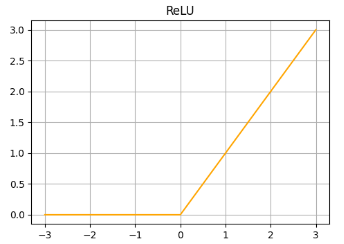

In [ ]:
funcao_ativacao = nn.ReLU()
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'ReLU')

## PReLU

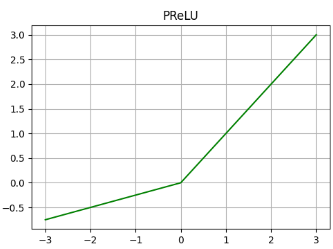

In [ ]:
funcao_ativacao = nn.PReLU()
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'PReLU')

## ELU

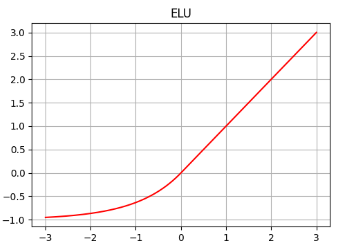

In [ ]:
funcao_ativacao = nn.ELU()
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'ELU')

## SELU

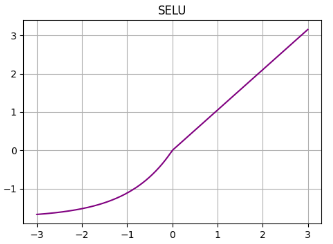![image.png]()

In [ ]:
funcao_ativacao = nn.SELU()
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'SELU')

## Tanh

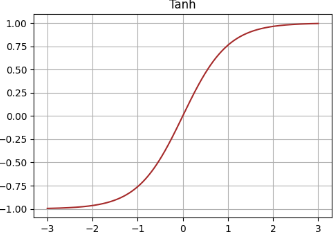

In [ ]:
funcao_ativacao = nn.Tanh()
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'Tanh')

## Sigmoid

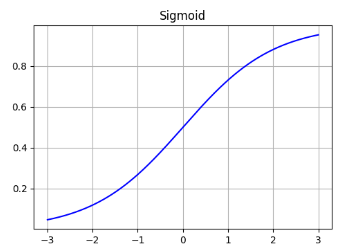

In [ ]:
funcao_ativacao = nn.Sigmoid()
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'Sigmoid')

## Wavelet Mexican Hat

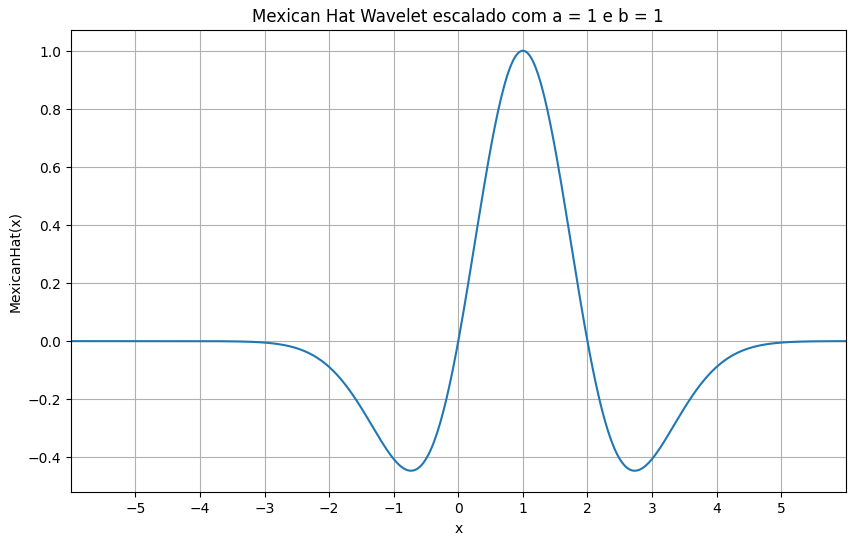

Com lr = 0.0001

In [ ]:
def mexican_hat_wavelet(x, a=1.0, b=1.0):
    """
    x : Tensor de entrada
    a : Escala (Stretch)
    b : Translação (Shift)
    """
    scaled_x = (x - b) / a
    return (1 - scaled_x**2) * torch.exp(-scaled_x**2 / 2)


class WaveletActivation(nn.Module):

  def __init__(self, scale=1.0, shift=1.0):
      super(WaveletActivation, self).__init__()
      self.scale = scale
      self.shift = shift

  def forward(self, x):
      return mexican_hat_wavelet(x, a=self.scale, b=self.shift)

funcao_ativacao = WaveletActivation(scale=1.0, shift=1.0)
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'MexicanHat')

Com lr = 0.001

In [ ]:
def mexican_hat_wavelet(x, a=1.0, b=1.0):
    """
    x : Tensor de entrada
    a : Escala (Stretch)
    b : Translação (Shift)
    """
    scaled_x = (x - b) / a
    return (1 - scaled_x**2) * torch.exp(-scaled_x**2 / 2)


class WaveletActivation(nn.Module):

  def __init__(self, scale=1.0, shift=1.0):
      super(WaveletActivation, self).__init__()
      self.scale = scale
      self.shift = shift

  def forward(self, x):
      return mexican_hat_wavelet(x, a=self.scale, b=self.shift)

funcao_ativacao = WaveletActivation(scale=1.0, shift=1.0)
testar_modelo_svm('/content/drive/MyDrive/Colab Notebooks/DatasetAumentadoArtigo1_3000_cut', funcao_ativacao, 'MexicanHat2')